In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime


In [107]:
api_key = 'MLJYMY9I99PI5JD0'
ts = TimeSeries(key=api_key, output_format='pandas')
data, _ = ts.get_daily(symbol='AAPL', outputsize='full')

data = data[['1. open', '2. high', '3. low', '4. close', '5. volume']]
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()


,Open,High,Low,Close,Volume
date,,,,,
2024-10-18,236.180,236.180,234.01,235.00,46431472.0
2024-10-21,234.450,236.850,234.45,236.48,36254470.0
2024-10-22,233.885,236.220,232.60,235.86,38846578.0
2024-10-23,234.080,235.144,227.76,230.76,52286979.0
2024-10-24,229.980,230.820,228.41,230.57,31109503.0


              Open         High          Low        Close        Volume
count  6286.000000  6286.000000  6286.000000  6286.000000  6.286000e+03
mean    174.259396   176.186004   172.233559   174.269481  3.313664e+07
std     147.094614   148.306319   145.683976   147.031187  3.057387e+07
min      12.990000    13.190000    12.720000    13.120000  7.025000e+05
25%      78.798750    79.647500    77.340000    78.455000  1.209955e+07
50%     139.055000   140.925000   137.095000   139.101000  2.462688e+07
75%     202.432500   204.677500   200.607500   202.832500  4.433798e+07
max     702.410000   705.070000   699.570000   702.100000  3.326072e+08


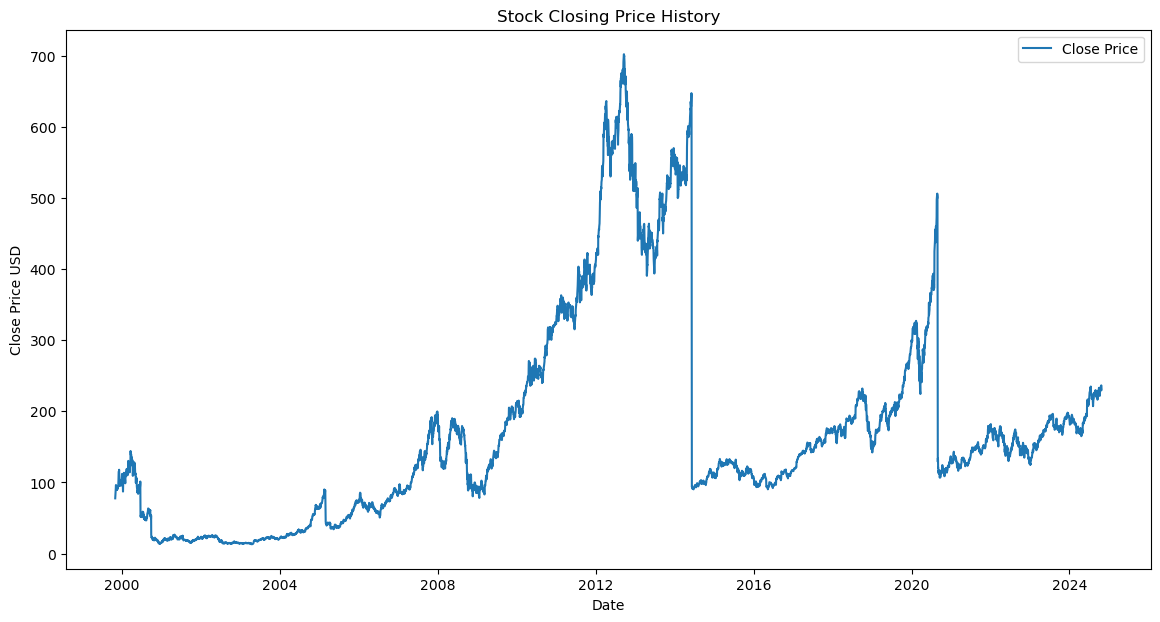

In [109]:
# Basic Stats
print(data.describe())

# Plot Close price over time
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()


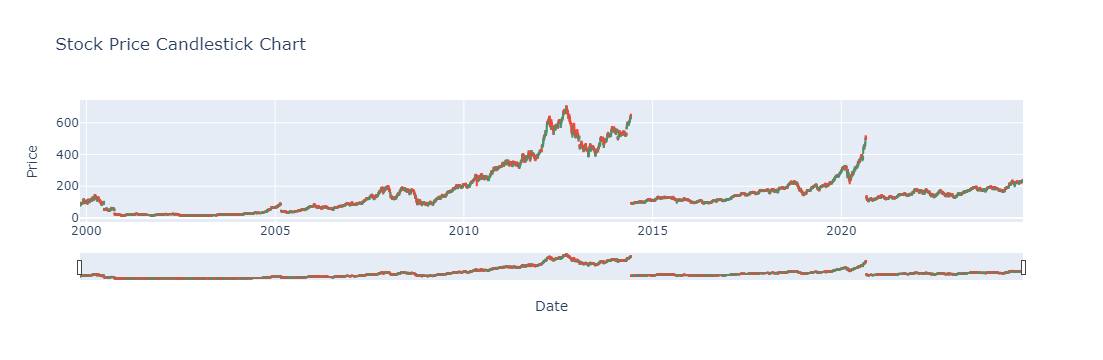

In [111]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                                     open=data['Open'],
                                     high=data['High'],
                                     low=data['Low'],
                                     close=data['Close'])])
fig.update_layout(title='Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


In [113]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['Close']])

# Prepare training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Helper function to create sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [115]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\yashdev\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0119
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.3902e-04
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.7040e-04
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.2366e-04
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.8032e-04
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 5.9773e-04
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 6.8081e-04
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.3058e-04
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8993e-04
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.0466e-04
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.1850e-04
Epoch 12/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8766e-04
Epoch 13/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.0813e-04
Epoch 14/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/s

In [119]:
model.save("Final_Stock.keras")

In [121]:
from tensorflow.keras.models import load_model
model = load_model("Final_Stock.keras")


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


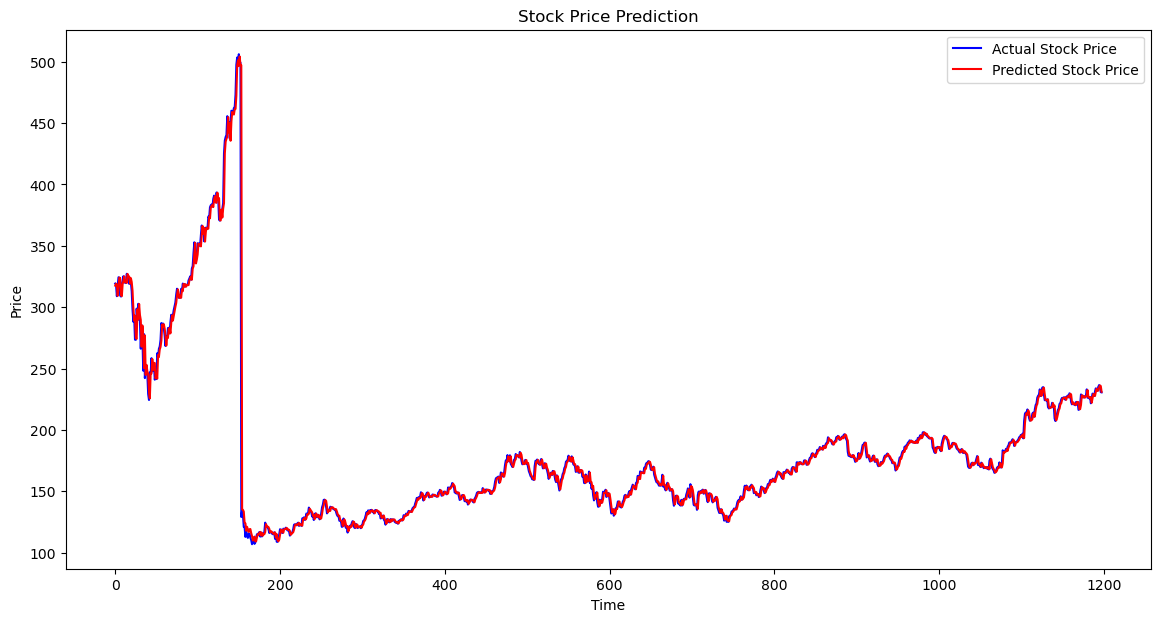

In [123]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform([y_test])

# Plot results
plt.figure(figsize=(14,7))
plt.plot(y_test_scaled[0], color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [127]:
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

predictions = []
for _ in range(3):
    next_pred = model.predict(last_sequence)
    predictions.append(scaler.inverse_transform(next_pred)[0][0])
    
    # Prepare `next_pred` for appending: reshape to (1, 1, 1)
    next_pred_reshaped = np.reshape(next_pred, (1, 1, 1))
    last_sequence = np.append(last_sequence[:, 1:, :], next_pred_reshaped, axis=1)

print("Predicted Prices for the Next 3 Days:", predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Prices for the Next 3 Days: [230.58318, 230.55838, 230.5266]


In [1]:
import numpy as np
import pandas as pd
import requests
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load your trained model
model = load_model('Final_Stock.keras')  # Replace with your actual model file path

# Function to fetch stock data from Alpha Vantage
def fetch_stock_data(symbol, api_key, interval='1min', outputsize='compact'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}&outputsize={outputsize}'
    response = requests.get(url)
    data = response.json()
    
    # Extract the time series data
    if 'Time Series (1min)' in data:
        df = pd.DataFrame(data['Time Series (1min)']).T
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df = df.astype(float)
        return df['close']
    else:
        raise ValueError("Error fetching data. Check the symbol and API key.")

# Function to prepare the data for prediction
def prepare_data(close_data, time_steps=60):
    # Create dataset with time steps
    data = close_data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    X = []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
    
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM
    return X, scaler

def predict_next_days(symbol, api_key, days=3):
    # Fetch data for the new stock
    close_data = fetch_stock_data(symbol, api_key)

    # Prepare the data for the first prediction
    X, scaler = prepare_data(close_data)

    predictions = []
    
    # Use the last available data for initial prediction
    last_data = X[-1].reshape(1, X.shape[1], 1)

    for _ in range(days):
        predicted_price = model.predict(last_data)
        predicted_price = scaler.inverse_transform(predicted_price)  # Inverse scale the predicted prices
        predictions.append(predicted_price[0][0])

        # Update last_data for the next prediction
        last_data = np.append(last_data[:, 1:, :], predicted_price.reshape(1, 1, 1), axis=1)

    return predictions

# Example usage
api_key = 'MLJYMY9I99PI5JD0'  # Replace with your actual API key
symbol = input("Enter Stock Symbol") 
predicted_prices = predict_next_days(symbol, api_key)
print(f"Predicted closing prices for the next three days for {symbol}: {predicted_prices}")



Enter Stock Symbol AAPL


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted closing prices for the next three days for AAPL: [231.35768, 233.11678, 232.68393]
